## Exploration of Image Transformations on RSNA Pneumonia Dataset


In [102]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from config import load_config
from rsna_dataloader import RSNAPneumoniaDataModule
# from transforms import preprocess_transforms, train_transforms

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
CONFIG_PATH = "config.yml"


configs = load_config(CONFIG_PATH)
NUM_IMAGES = configs["inference"]["predict_size"] = 8
IMG_INDICES = [0,1,2,3,4,5,6,7]

rsna = RSNAPneumoniaDataModule(configs)
predict_dataloader = rsna.predict_dataloader(IMG_INDICES, transforms.ToTensor())
original_imgs = next(iter(predict_dataloader))

# def plot(batch):
#     _, ax = plt.subplots(2, NUM_IMAGES//2, figsize=(NUM_IMAGES*1, 4))
#     idx = 0
#     for r in range(2):
#         for c in range(NUM_IMAGES//2):
#             img = batch["image"][idx].squeeze().permute(1,2,0).int()
#             ax[r][c].set_title("Label: " + str(batch["target"][idx].item()))
#             ax[r][c].imshow(img, cmap="gray")
#             ax[r][c].axis("off")
#             idx+=1

def plot(batch, title):
    fig, ax = plt.subplots(1, NUM_IMAGES, figsize=(NUM_IMAGES*2, 2.5))
    fig.suptitle(title)
    for i in range(NUM_IMAGES):
        img = batch["image"][i].squeeze().permute(1,2,0).int()
        ax[i].set_title("Label: " + str(batch["target"][i].item()))
        ax[i].imshow(img, cmap="gray")
        ax[i].axis("off")


DISTRIBUTION LABEL BY GENDER
label_rsna_pneumonia     False     True 
Patient Gender                          
F                     0.782775  0.217225
M                     0.768561  0.231439
#train:  20412
#val:    2269
#test:   4003


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/leeping/miniconda3/envs/mira/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/leeping/miniconda3/envs/mira/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/leeping/miniconda3/envs/mira/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/leeping/Repos/med-img-monitoring/src/rsna_dataloader.py", line 45, in __getitem__
    "image": self.transform(scan_image),
TypeError: 'NoneType' object is not callable


### 1. Original Images From Test Set

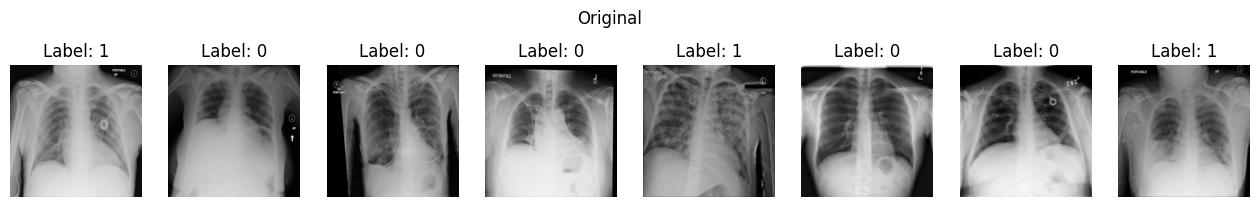

In [ ]:
plot(original_imgs, title="Original")

### 2. Preprocessing and Augmentation for Model Training

#### 2.1 Preprocessing: Resize + Center Crop
Resize to 256 then center crop to:
- Remove text along edges
- Focus more on lungs

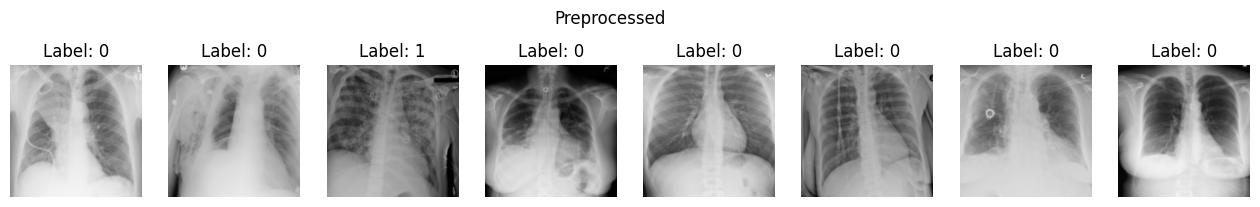

In [ ]:
preprocess_transforms = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize(256, antialias=True), 
                                transforms.CenterCrop(224)])
predict_dataloader = rsna.predict_dataloader(IMG_INDICES, preprocess_transforms)
preprocessed_imgs = next(iter(predict_dataloader))
plot(preprocessed_imgs, title="Preprocessed")

#### 2.2 Augmentation: Rotation, Horizontal Flip, Resized Crop

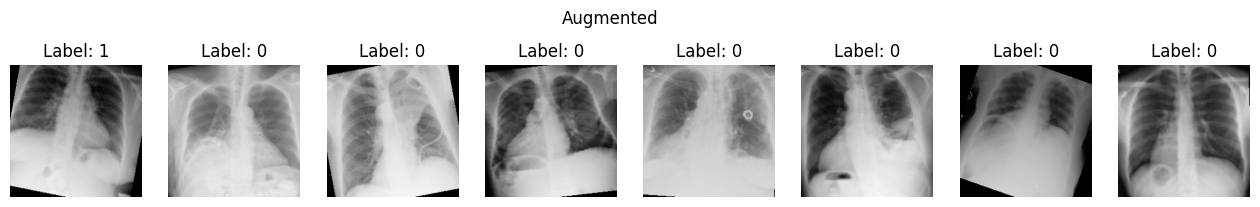

In [ ]:
transform = transforms.Compose([preprocess_transforms,
                                transforms.RandomRotation(20),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomResizedCrop(224, (0.9, 1), antialias=True)])
predict_dataloader = rsna.predict_dataloader(IMG_INDICES, transform)
augmented_imgs = next(iter(predict_dataloader))
plot(augmented_imgs, title="Augmented")

### 3. Synthetic Data Shifts

#### 3.1 Contrast

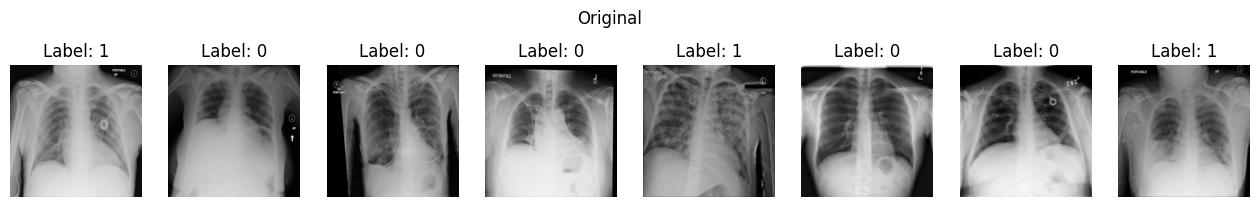

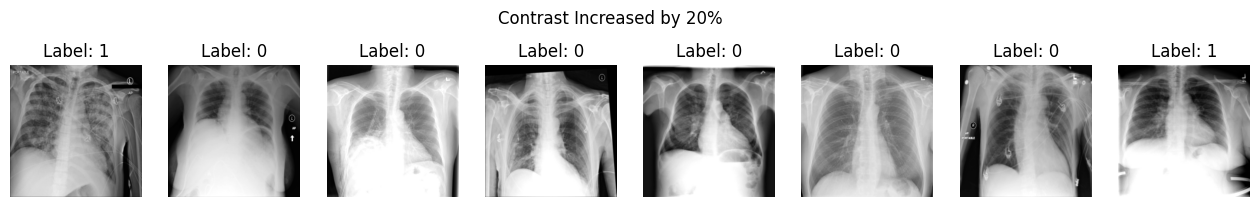

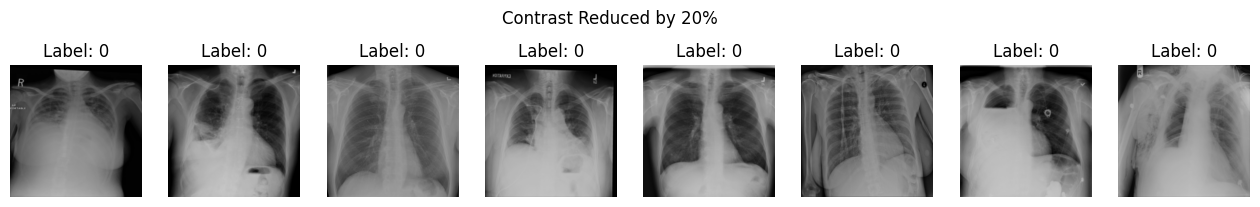

In [ ]:
class ContrastTransform:
    def __init__(self, gain):
        self.gain = gain

    def __call__(self, img):
        # output = gain*input + bias
        return (img*self.gain).clip(min=0., max=255.)


transform_c120 = transforms.Compose([transforms.ToTensor(), ContrastTransform(1.2)])
dataloader_c120 = rsna.predict_dataloader(IMG_INDICES, transform_c120)
contrast_120_imgs = next(iter(dataloader_c120))

transform_c80 = transforms.Compose([transforms.ToTensor(), ContrastTransform(0.8)])
dataloader_c80 = rsna.predict_dataloader(IMG_INDICES, transform_c80)
contrast_80_imgs = next(iter(dataloader_c80))

plot(original_imgs, title="Original")
plot(contrast_120_imgs, title="Contrast Increased by 20%")
plot(contrast_80_imgs, title="Contrast Reduced by 20%")


#### 3.2 Noise

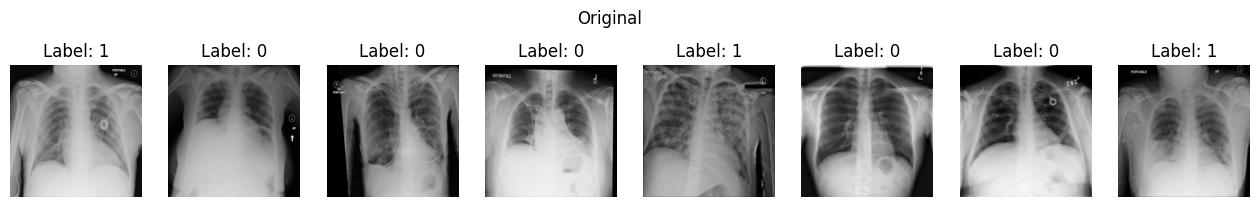

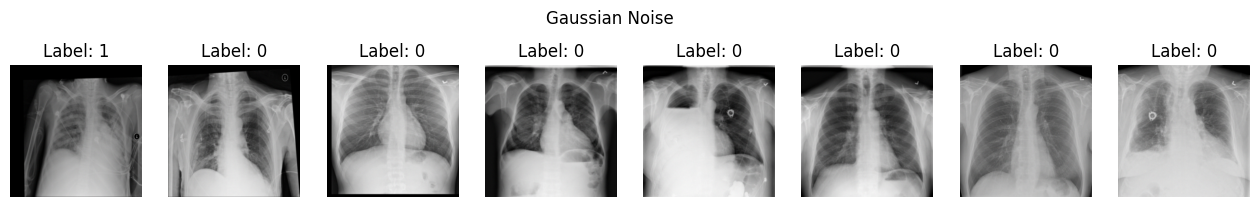

In [ ]:
class GaussianNoiseTransform:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return (tensor + torch.randn(tensor.size()) * self.std + self.mean).clip(min=0., max=255.)


transform_gn = transforms.Compose([transforms.ToTensor(), GaussianNoiseTransform(mean=0., std=1.)])
dataloader_gn  = rsna.predict_dataloader(IMG_INDICES, transform_gn)
gaussian_noise_imgs = next(iter(dataloader_gn))

plot(original_imgs, title="Original")
plot(gaussian_noise_imgs, title="Gaussian Noise")

In [ ]:
for i, loader in enumerate(predict_dataloader):
    print(i)

0
1
2
3


In [ ]:
import random

random.seed(0)
for i in range(10):
    print(random.randint(0,100))

49
97
53
5
33
65
62
51
100
38


In [ ]:
random.seed(0)
for i in range(10):
    print(random.randint(0,100))

49
97
53
5
33
65
62
51
100
38


In [ ]:
for i in range(10):
    print(random.randint(0,100))

61
45
74
27
64
17
36
17
96
12
